<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_lfw_experiment_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T152011Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db4ec61946419ca8b830a0f4613cac81dffb050d7d712972d73e73a8d24cc40a231fb1a47a2c7bce99a68ff93e9ac40d5a337ede5b14e8940c63ba216337c90b4cc432075b2f24e158971a25f9ecb52e84512e1cdc8473afcdfc20275099542b8cc23208d379bed1a7e644e96a929b7dbb91a7019f5331c94ea9f46d05bdd60badb9169961ed1faa90ae1290e3919c42a5736aa4fd68b941df0dac0e6957e4528a6663da154303292f0925fe7bc92d10ad202845647f7a1eff66f586604bb52c0626b2d95f3daf452d5dae6be3e0f2daf1e3177513be89acda9a7114a083009f77cf36a5edd56f41bb1bf1ba424974542d3b8bd7ac3ec5ab7122a096e033e4df9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [ ]:
# !pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.6 MB/s eta 0:00:00


In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


In [3]:
# Set the dataset path
dataset_path = '../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Generate a list of (name, image count) tuples
names_images = []

for name in os.listdir(dataset_path):
    directory = os.path.join(dataset_path, name)
    if os.path.isdir(directory):
        images = [i for i in os.listdir(directory) if i.endswith('.jpg')]
        image_count = len(images)
        # Add to list if there are at least 25 images and store the actual image count
        if image_count >= 50:
            names_images.append((name, min(image_count, 50)))

# Update number_of_people to reflect the actual number of people with at least 25 images
number_of_people = len(names_images)
print(f"Number of people with at least 50 images: {number_of_people}")

# Create a DataFrame
lfw_allnames = pd.DataFrame(names_images, columns=['name', 'images'])

# Save the DataFrame to a CSV file
lfw_csv_path = '../input/lfw-dataset/lfw_allnames.csv'
lfw_allnames.to_csv(lfw_csv_path, index=False)

# print(f"CSV file created at: {lfw_csv_path}")

Number of people with at least 50 images: 12


In [4]:
# Define a new directory for experiments
new_dir_path = '../lfw-data-experiment'

# Create the new directory if it doesn't exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

# Move the folders
for name, image_count in names_images:
    source_folder = os.path.join(dataset_path, name)
    destination_folder = os.path.join(new_dir_path, name)

    # Check if the destination folder already exists
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)

    # Move the folders
    if os.path.exists(source_folder):
        shutil.copytree(source_folder, destination_folder)
        # If there are more than 50 images, keep the first 50 and delete the rest
        images = sorted([i for i in os.listdir(destination_folder) if i.endswith('.jpg')])
        for img in images[50:]:  # Delete all images beyond the 25th
            os.remove(os.path.join(destination_folder, img))
    else:
        print(f"Folder for {name} does not exist in the dataset path.")

print("Folders moved successfully.")

Folders moved successfully.


In [5]:

# Read the dataset
people_data = os.listdir(new_dir_path)
people = []
for item in people_data:
    person_images = os.listdir(os.path.join(new_dir_path, item))
    for person_image in person_images:
        people.append((item, os.path.join(new_dir_path, item, person_image)))

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Convert labels to one-hot encoded labels
label_encoder = LabelEncoder()
labels = people_df['person'].values
int_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(int_encoded)

# Correct the size of the images to match the CNN input
im_size = 150

# Initialize lists to store the images and labels
images = []
labels = []

# Load and preprocess the images
for index, row in people_df.iterrows():
    img = cv2.imread(row['path'])
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(row['person'])

images = np.array(images)
images = images.astype('float32') / 255.0

# Shuffle and split the dataset
images, y_onehot = shuffle(images, y_onehot, random_state=1)
train_x, test_x, train_y_onehot, test_y_onehot = train_test_split(images, y_onehot, test_size=0.3, random_state=415)

# Check the shapes again to make sure they match
print("train_x shape:", train_x.shape)
print("train_y_onehot shape:", train_y_onehot.shape)
print("test_x shape:", test_x.shape)
print("test_y_onehot shape:", test_y_onehot.shape)

train_x shape: (420, 150, 150, 3)
train_y_onehot shape: (420, 12)
test_x shape: (180, 150, 150, 3)
test_y_onehot shape: (180, 12)


In [ ]:
# import os

# # Correct path according to your folder structure
# lfw_data_experiment = '../lfw-data-experiment'

# people_data = os.listdir(lfw_data_experiment)
# print(len(people_data))

# people = []
# for item in people_data:
#     all_names = os.listdir(lfw_data_experiment + '/' + item)
#     for person in all_names:
#         people.append((item, lfw_data_experiment + '/' + item + '/' + person))

# print(people)


In [6]:
import pandas as pd

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Count the number of samples for each person
person_count = people_df['person'].value_counts()

print("Total number of images of people in the dataset: ", len(people_df))
print("Samples in each category: ")
print(person_count)


Total number of images of people in the dataset:  600
Samples in each category: 
person
Junichiro_Koizumi    50
Tony_Blair           50
George_W_Bush        50
Serena_Williams      50
Jacques_Chirac       50
Colin_Powell         50
Jean_Chretien        50
Ariel_Sharon         50
Donald_Rumsfeld      50
John_Ashcroft        50
Gerhard_Schroeder    50
Hugo_Chavez          50
Name: count, dtype: int64


#Encoding

In [7]:
num_classes = len(np.unique(labels))

In [8]:
im_shape=(im_size, im_size, 3)

In [10]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',#'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 144, 144, 36)      5328      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 72, 72, 36)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 68, 68, 54)        48654     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 34, 34, 54)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 62424)             0         
                                                                 
 dense_4 (Dense)             (None, 2024)             

In [11]:
history = cnn_model.fit(
    train_x,
    train_y_onehot,
    epochs=50,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)


Epoch 1/50
14/14 [==============================] - 9s 138ms/step - loss: 3.6394 - accuracy: 0.0810 - val_loss: 2.4849 - val_accuracy: 0.0833
Epoch 2/50
14/14 [==============================] - 1s 71ms/step - loss: 2.4864 - accuracy: 0.0762 - val_loss: 2.4788 - val_accuracy: 0.1222
Epoch 3/50
14/14 [==============================] - 1s 69ms/step - loss: 2.4820 - accuracy: 0.1119 - val_loss: 2.4678 - val_accuracy: 0.1167
Epoch 4/50
14/14 [==============================] - 1s 74ms/step - loss: 2.4656 - accuracy: 0.1333 - val_loss: 2.4701 - val_accuracy: 0.1889
Epoch 5/50
14/14 [==============================] - 1s 75ms/step - loss: 2.4782 - accuracy: 0.1476 - val_loss: 2.4434 - val_accuracy: 0.1833
Epoch 6/50
14/14 [==============================] - 1s 72ms/step - loss: 2.3601 - accuracy: 0.2000 - val_loss: 2.2927 - val_accuracy: 0.2222
Epoch 7/50
14/14 [==============================] - 1s 67ms/step - loss: 2.1816 - accuracy: 0.2571 - val_loss: 2.1929 - val_accuracy: 0.2944
Epoch 8/50
1

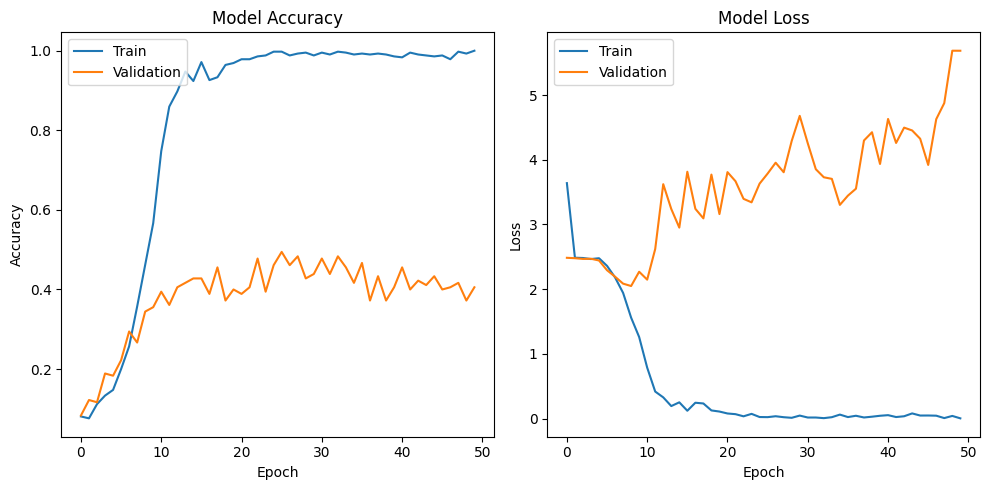

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


6/6 [==============================] - 0s 21ms/step


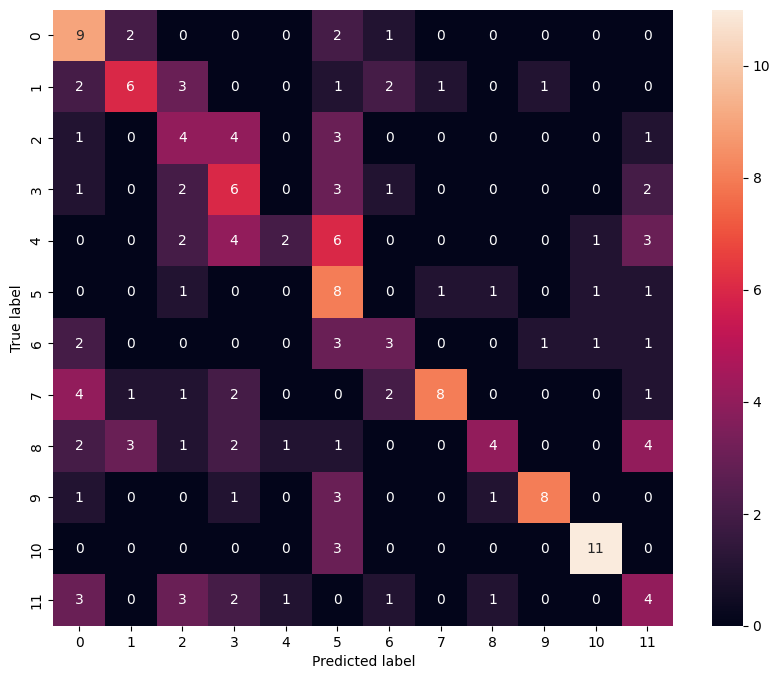

                   precision    recall  f1-score   support

     Ariel_Sharon       0.36      0.64      0.46        14
     Colin_Powell       0.50      0.38      0.43        16
  Donald_Rumsfeld       0.24      0.31      0.27        13
    George_W_Bush       0.29      0.40      0.33        15
Gerhard_Schroeder       0.50      0.11      0.18        18
      Hugo_Chavez       0.24      0.62      0.35        13
   Jacques_Chirac       0.30      0.27      0.29        11
    Jean_Chretien       0.80      0.42      0.55        19
    John_Ashcroft       0.57      0.22      0.32        18
Junichiro_Koizumi       0.80      0.57      0.67        14
  Serena_Williams       0.79      0.79      0.79        14
       Tony_Blair       0.24      0.27      0.25        15

         accuracy                           0.41       180
        macro avg       0.47      0.42      0.41       180
     weighted avg       0.48      0.41      0.41       180



In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model  # if you have a model to load, otherwise import your CNN architecture

# Assuming your CNN has been trained and you have the model loaded
# model = load_model('your_model.h5')  # Load your trained model

# Generate predictions
test_y_pred = cnn_model.predict(test_x)
test_y_pred_classes = np.argmax(test_y_pred, axis=1)
test_y_true = np.argmax(test_y_onehot, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(test_y_true, test_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print(classification_report(test_y_true, test_y_pred_classes, target_names=label_encoder.classes_))
